# Predicting Tritium Thermo-Desorption Spectra

___

### Context

Tritium is an isotope of Hydrogen used as a fuel in fusion research. In testing, the reactor walls are bombarded by tritium isotopes, which enter the metal lattice, and travel through diffusion.

When a reactor wall is removed, the trapped tritium is a huge threat. It is radiactive and will slowly escape into the atmosphere, potentialy causing harm. The cost of decomissioning tritiated metal is estimated at $5,000,000 per gram of tritium. This massive cost makes understanding the behaviour of different materials valuable.

### Trapping Sites

Irregularities in the lattice structure exist. Tritium atoms can become trapped in areas near these irregularities by forces exerted by the metal ions. These are known as trapping sites, and they cause the material to retain tritium indefinatly. Without increasing the energy of the system, tritium cannot escape.

The structure of the metal lattice means there is a limited number of trapping site types. Each type has a characteristic energy, below which tirium atoms escaping is impossible.

<div>
<img src="resources/images/lattice.png" width="800"/>
<center>
    <a href="https://theses.hal.science/tel-04004369"> Interactions of solute hydrogen in tungsten. [Rémi Delaporte-Mathurin]</a>
<center/>
</div>

### Thermal-Desorption Spectrometry

When tritiated metal is heated, the tritium gains enough energy to escape the trapping sides and is free to diffuse out of the metal. This process is called desorption and it's measured using Thermal-Desorption (TD) Spectrometry .

TD spectrometry experiments involve slowly heating tritiated metal, and measuring the amount of tritium that escapes over a given time period. The result is the amount of tritium exiting a given area of the sample over a known time interval as a function of temperature.

$$
D = f(T)
$$

TD spectrum of samples changes with material because differences in their composition and structure result in different energies required to escape their trapping sites.

The amount of tritium in a sample and its TD spectrum are reliant on the energy $E_i$ needed to escape a type of trapping site $i$, and the number of the trapping sites in a known area of the material $n_i$.

*** 

### ML Challenge 

Researchers are interested in identifying the trapping energies and desnities $E_i$ and $n_i$ of the materials they are using in their reactors to minimise the amount of tritium trapped in the walls of their future designs.

They have developed a simulation of the TD spectrometry experiment that can calculate the TD spectrum of a given set of trapping enegies and densities. The simulation takes a very long time to complete, even on powerful computers.

The aim then, is to use the limited number of simulated experiments to identify the trapping energies and densities that produced the real TD spectrum of a sample.

### twinLab Solution

twinLab is able to use a trained emulator to indenitfy the inputs that were most likely to produce a given output using the `emulator.calibrate`.

To test this we will:

1. Split our Thermal Desrption Dataset into training and test data.
2. Train our emulator to predict Thermal Desrption Spectrum from $E_i$ and $n_i$.
3. Use `twinlab.calibrate` to identify the $E_i$ and $n_i$ that produced the test data outputs.
4. Compare the `twinLab` calibration and the true test data inputs.



***

### Imports

In [1]:
import twinlab

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fusion_energy.plot import plot_test, style_axes


          ====== TwinLab Client Initialisation ======
          Version     : 2.9.0
          Server      : https://twinlab.digilab.co.uk
          Environment : /Users/joe/repos/FusionEnergy/.env



***

### Downloading Data

The dataset is available on the `twinLab` cloud as an example. 

In [2]:
data = twinlab.load_example_dataset('tritium-desorption', verbose = False)

***

### Inputs

The inputs $\vec{x}$ are $(E_1, E_2, E_3, n1, n2)$


In [3]:
inputs = data.columns[:5].to_list()
data[inputs][:3]

,E1,E2,E3,n1,n2
0,0.726163,1.248766,1.128671,0.002004,0.000307
1,0.787837,0.925174,1.226117,0.001564,0.000768
2,0.710103,0.902457,1.558539,0.004860,0.000613


___

### Outputs

Every simulation $D = f(T)$ outputs 624 many the tritium desorption rates $D_n$ at each temperature $T_n$. 

Our temperatures are equally spaced and can be calculated using numpy's `np.linspace`.


___

In [4]:
outputs = [f"D{n}" for n in range(624)]

In [5]:
temperatures = pd.DataFrame(np.linspace(300, 800, len(outputs))).T
temperatures.columns = [f"T{n}" for n in range(len(outputs))]
temperatures

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T614,T615,T616,T617,T618,T619,T620,T621,T622,T623
0,300.0,300.802568,301.605136,302.407705,303.210273,304.012841,304.815409,305.617978,306.420546,307.223114,...,792.776886,793.579454,794.382022,795.184591,795.987159,796.789727,797.592295,798.394864,799.197432,800.0


In [6]:
data.columns = inputs + outputs

In [7]:
data[outputs][:3]

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D614,D615,D616,D617,D618,D619,D620,D621,D622,D623
0,1.511613e+17,1.626357e+17,1.749599e+17,1.881609e+17,2.022474e+17,2.171753e+17,2.329431e+17,2.501679e+17,2.681171e+17,2.873808e+17,...,2.318606e+17,2.304607e+17,2.290609e+17,2.276611e+17,2.262613e+17,2.248615e+17,2.234616e+17,2.220618e+17,2.206620e+17,2.192622e+17
1,7.621430e+16,8.255297e+16,8.942421e+16,9.684174e+16,1.048160e+17,1.133235e+17,1.223659e+17,1.323483e+17,1.428036e+17,1.541191e+17,...,2.728998e+16,2.706896e+16,2.684793e+16,2.662690e+16,2.640587e+16,2.618484e+16,2.596381e+16,2.574279e+16,2.552176e+16,2.530073e+16
2,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,3.390432e+17,3.631858e+17,3.895231e+17,4.169486e+17,4.463476e+17,...,2.079730e+16,2.078486e+16,2.077242e+16,2.075998e+16,2.074754e+16,2.073510e+16,2.072265e+16,2.071021e+16,2.069777e+16,2.068533e+16


***

### Uploading data

We'll create a copy of the example dataset in the `twinLab` cloud to work with.

In [8]:
dataset = twinlab.Dataset("tritium_desorption")
dataset.upload(data, verbose = False)

***

### Workflow



### Dimensionality reduction

Our dataset has 624 outputs or ***dimensions***, which makes our problem complicated. Luckily we can make it simpler using `twinLab`. 

`twinLab` can learn to reperesent our outputs in fewer dimensions. This makes training and evaluating our emulator faster and cheaper. `twinLab` then reconstructs the more complex outputs when you need them, and you won't be able to tell the difference.

To check if this will work for our problem, we need to:

1. See how well our data can be represented using fewer dimensions.
2. Select a sensible number of dimensions to use.

We can do this using the `analyse_variance` function of our `twinLab` dataset, which tells us how well we can represent our original data using a given number of dimensions.

In [9]:
variance = dataset.analyse_variance(outputs)[1:11]
variance

,Number of Dimensions,Cumulative Variance
1,1,0.265579
2,2,0.734992
3,3,0.895238
4,4,0.969070
5,5,0.989724
6,6,0.996053
7,7,0.998313
8,8,0.999210
9,9,0.999563
10,10,0.999722


In [10]:
number_dimensions = variance['Number of Dimensions'][1:11]
cumulative_variance = variance['Cumulative Variance'][1:10]

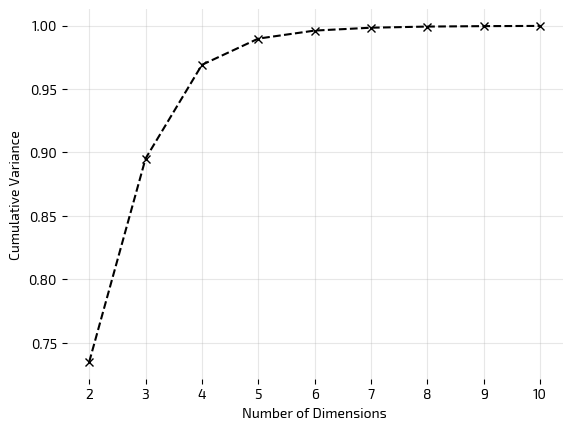

In [11]:
plt.plot(number_dimensions, cumulative_variance, 'kx--')
plt.ylabel("Cumulative Variance")
plt.xlabel("Number of Dimensions")
style_axes(plt.gca())
plt.show()


*** 

### Emulation

Our emulator will use an input $(E_1, E_2, E_3, n_1, n_2)$ to predict the desorption rate and the uncertainty at every temperature. This is a functional emulator because each input corrasponds to the output of a function.

Before we can start training, we will set aside 20% of our data to test our emulator. This data won't be used in training and will be used to check how our emulator performs on "new" data.

<!-- We will use a `single_task_gp` estimator, because ...
 how the emulator performs on new inputs.
 -->

To get started we will:
1. Create an emulator on the `twinlab` cloud.

In [12]:
emulator = twinlab.Emulator('tritium_desorption') 

2. Set our training parameters.

In [13]:
train_test_ratio = 0.8
output_retained_dimensions = 8

In [14]:
train_params = twinlab.TrainParams(
    train_test_ratio = train_test_ratio,
    output_retained_dimensions = output_retained_dimensions,
    seed = 42
)

3. Start!

In [15]:
emulator.train(dataset, inputs, outputs, train_params, verbose = False)

### Score

Now the emulator is trained, we can use `emulator.score` to see how well it performs.
We're going to use the Root Mean Squared Error (MSE) metric.

In [16]:
rmse = np.sqrt(emulator.score(tl.ScoreParams(metric = 'RMSE', combined_score = True)))
print(f"RMSE  = {rmse:.3e}")

NameError: name 'tl' is not defined

In [ ]:
test_data = emulator.view_test_data()

In [ ]:
mean, std = emulator.predict(test_data[inputs], verbose=False)

*** 

### Test the emulator 

In [ ]:
i = np.random.randint(0, test_data.shape[0])

In [ ]:
plot_test(i, test_data, mean, std, temperatures)
plt.show()

### Calibration

# Load the streamlit App

In [ ]:
%%capture
# !streamlit run app.py